In [1]:
# %% 
import os
import math
from functools import partial

import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from datasets import load_from_disk  
from flax import nnx                                
import orbax.checkpoint as ocp                      
import optax                                         
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

/opt/anaconda3/envs/jax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## 2. Load Preprocessed Dataset


DATA_DIR = "./processed_bird_dataset"

# Load HF Arrow dataset
ds = load_from_disk(DATA_DIR)

# Split 80/20
split = ds.train_test_split(test_size=0.2, seed=0)
train_ds = split["train"]
test_ds  = split["test"]

# Convert to NumPy for JAX (spectrograms are float32, labels float32 one-hots)
train_ds = train_ds.with_format("numpy")
test_ds  = test_ds.with_format("numpy")

BATCH_SIZE = 32

feat_shape = train_ds.features["features"].shape     # e.g. (128, N_FRAMES, 1) 128 mel bands (rows) 
label_len  = train_ds.features["labels"].length      # e.g. NUM_CLASSES

def to_tf_dataset(hf_ds):
    def gen():
        for ex in hf_ds:
            yield ex["features"], ex["labels"]
    return (
        tf.data.Dataset
          .from_generator(
              gen,
              output_signature=(
                  tf.TensorSpec(shape=feat_shape, dtype=tf.float32),
                  tf.TensorSpec(shape=(label_len,), dtype=tf.int32),
              )
          )
          .shuffle(1024)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE)
    )

train_tf = to_tf_dataset(train_ds)
test_tf  = to_tf_dataset(test_ds)

In [3]:
train_tf

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 313, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 206), dtype=tf.int32, name=None))>

	•	CHUNK_DURATION = 5 s
	•	SR = 32 000 Hz → CHUNK_SAMPLES = 5 × 32 000 = 160 000 samples
	•	HOP_LENGTH = 512 samples between successive STFT windows

```
N_FRAMES = ceil(160 000 / 512) ≈ ceil(312.5) = 313
```

In [4]:
def pd(n): return (n - 2)//2 + 1  
H2 = pd(pd(128))
W2 = pd(pd(313))
flatten_dim = 64 * H2 * W2

print("Flatten dim:", flatten_dim)

Flatten dim: 159744


In [5]:
## 3. Define the CNN Model

class AudioCNN(nnx.Module):
    """Basic CNN for log-mel spectrograms."""
    def __init__(self, num_classes, rngs: nnx.Rngs):
        self.conv1 = nnx.Conv(1, 32, kernel_size=(3,3), rngs=rngs)
        self.conv2 = nnx.Conv(32, 64, kernel_size=(3,3), rngs=rngs)
        self.pool  = partial(nnx.avg_pool, window_shape=(2,2), strides=(2,2))
        
        self.dense = nnx.Linear(159744, 128, rngs=rngs)
        self.out   = nnx.Linear(128, num_classes, rngs=rngs)

    def __call__(self, x):
        x = self.pool(nnx.relu(self.conv1(x)))
        x = self.pool(nnx.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = nnx.sigmoid(self.dense(x))
        return self.out(x)

# Instantiate with a dummy batch to infer shapes
# Grab metadata from train_ds
N_MELS    = feat_shape[0]
N_FRAMES  = feat_shape[1]
NUM_CLASSES = label_len

model = AudioCNN(NUM_CLASSES, rngs=nnx.Rngs(0))
nnx.display(model)  

In [6]:
## 4. Optimizer & Metrics

learning_rate = 1e-3
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate))
metrics  = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss'),
)
nnx.display(optimizer)

In [7]:
## 5. Train & Eval Steps

def loss_fn(model, batch):
    imgs, labels = batch
    logits = model(imgs)
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    return loss, logits

@nnx.jit
def train_step(model, optimizer, metrics, batch):
    (loss, logits), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model, batch)

    labels_int = jnp.argmax(batch[1], axis=-1)
    metrics.update(loss=loss, logits=logits, labels=labels_int) # Pass labels_int here

    # metrics.update(loss=loss, logits=logits, labels=batch[1])
    optimizer.update(grads)
    return loss

@nnx.jit
def eval_step(model, metrics, batch):
    loss, logits = loss_fn(model, batch)

    labels_int = jnp.argmax(batch[1], axis=-1)
    metrics.update(loss=loss, logits=logits, labels=labels_int)
    # metrics.update(loss=loss, logits=logits, labels=batch[1])

In [8]:
from tqdm.auto import tqdm

EPOCHS = 3
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[]}

num_train_steps = math.ceil(len(train_ds) / BATCH_SIZE)
num_test_steps  = math.ceil(len(test_ds)  / BATCH_SIZE)

for epoch in range(EPOCHS):
    train_np = train_tf.as_numpy_iterator()
    train_bar = tqdm(
        train_np,
        total=num_train_steps,
        desc=f"Epoch {epoch+1}/{EPOCHS} [train]",
        leave=False
    )
    for imgs, labels in train_bar:
        loss = train_step(model, optimizer, metrics, (imgs, labels))
        train_bar.set_postfix(train_loss=f"{loss:.4f}")

    tr_metrics = metrics.compute(); metrics.reset()
    history['train_loss'].append(tr_metrics['loss'])
    history['train_acc'].append(tr_metrics['accuracy'])

    test_np = test_tf.as_numpy_iterator()
    test_bar = tqdm(
        test_np,
        total=num_test_steps,
        desc=f"Epoch {epoch+1}/{EPOCHS} [eval]",
        leave=False
    )
    for imgs, labels in test_bar:
        eval_step(model, metrics, (imgs, labels))

    te_metrics = metrics.compute(); metrics.reset()
    history['test_loss'].append(te_metrics['loss'])
    history['test_acc'].append(te_metrics['accuracy'])

    # --- Print epoch summary ---
    print(f"Epoch {epoch+1}/{EPOCHS} [train] loss: {tr_metrics['loss']:.4f}, acc: {tr_metrics['accuracy']:.4f}")
    print(f"Epoch {epoch+1}/{EPOCHS} [eval]  loss: {te_metrics['loss']:.4f}, acc: {te_metrics['accuracy']:.4f}")
    print("-" * 50)

Epoch 1/3 [train] loss: 0.0371, acc: 0.0407
Epoch 1/3 [eval]  loss: 0.0341, acc: 0.0419
--------------------------------------------------


Epoch 2/3 [train] loss: 0.0341, acc: 0.0405
Epoch 2/3 [eval]  loss: 0.0341, acc: 0.0419
--------------------------------------------------


Epoch 3/3 [train] loss: 0.0341, acc: 0.0407
Epoch 3/3 [eval]  loss: 0.0341, acc: 0.0419
--------------------------------------------------


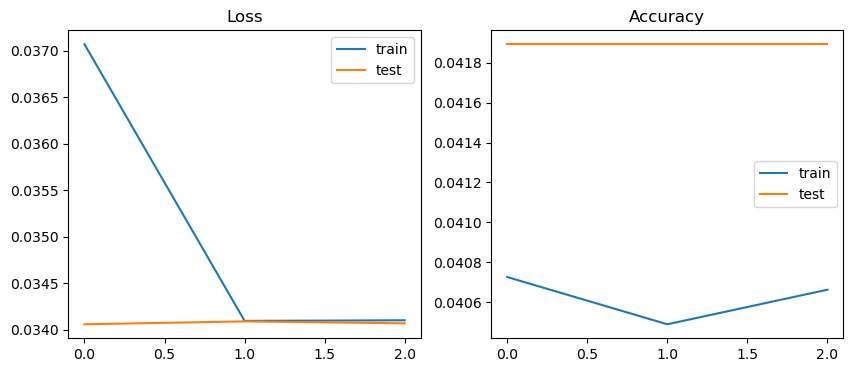

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train')
plt.plot(history['test_loss'], label='test')
plt.title(f'Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train')
plt.plot(history['test_acc'], label='test')
plt.title(f'Accuracy')
plt.legend()
plt.show()

In [14]:
## 7. Checkpointing

# Directory for checkpoints
CKPT_DIR = os.path.join(os.getcwd() , "./checkpoints")
ckpt = ocp.StandardCheckpointer()

# Extract the NNX state (parameters + any batch-norm stats, etc.)
_, state = nnx.split(model)

experiment_name = "bird_classifier"
experiment_dir = os.path.join(CKPT_DIR, experiment_name)
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

# Save the model state
ckpt.save(os.path.join(experiment_dir, "model_state"), state)
# Save the training history
history_path = os.path.join(experiment_dir, "history.npz")
np.savez(
    history_path,
    train_loss=history['train_loss'],
    train_acc=history['train_acc'],
    test_loss=history['test_loss'],
    test_acc=history['test_acc'],
)

In [ ]:
# # Later… restore:
# abstract_model = nnx.eval_shape(lambda: AudioCNN(NUM_CLASSES, rngs=nnx.Rngs(0)))
# graphdef, abstract_state = nnx.split(abstract_model)
# restored_state = ckpt.restore(os.path.join(CKPT_DIR, "model_state"), abstract_state)
# model = nnx.merge(graphdef, restored_state)

# # Restore optimizer state
# opt_state = ckpt.restore(os.path.join(CKPT_DIR, "optim_state"), optimizer.state_dict())
# optimizer = optimizer.replace_state(opt_state)